# $5^{th}$ exercises
## Notebook setup
#### Used libraries

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb as rgb
from math import sin, cos, radians
from mpl_toolkits.mplot3d import Axes3D

#### Functions

In [3]:
#Load and print config files
def LoadConf(path,T=int):
    d={}
    with open(path) as file:
        for line in file:
            (directive,key, val) = line.split()
            if(directive=="#define"): d[key] = T(val)
    return d

def PrintConf(d):
    for key, val in d.items(): print("{0:<19}{1}".format(key,val))
        
#Plot shortcuts
def PlotSetup():
    plt.axes().set_facecolor(bg1)
    plt.grid(alpha=0.3)

def MultiplotSetup(fig,r,c):
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        fig.axes[i].set_facecolor(bg1)
        plt.grid(alpha=0.3) 
    
def Legend():
    leg = plt.legend(facecolor=bg2)
    for text in leg.get_texts():
        text.set_color(el1)
        
def Errbar1Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.plot(x,y,color=el1)
    
def Errbar2Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4, label="$2\sigma$")
    plt.plot(x,y,color=el1)

#### Colors, just for fun

In [4]:
#background
bg1 = "#191724" 
bg2 = "#26233a" 
#elements
el1 = "#e0def4" 
el2 = "#f6c177" 
el3 = "#eb6f92" 
#errorbars
er1 = "#908caa"  
er2 = "#6e6a86"

## 05.1 Hydrogen atom
### Introductory notes
The hydrogen atom is the only atom whose Schrodigner equation has been solved exactly. Actually we have that a general eigenfunction of $H_1$ is expressed in terms of exponentials, spherical harmonics and generalized Laguerre polinomials and is caracterized by three quantum numbers, $n,l,m$. Hence we can use the notation $\Psi_{n,l,m}$. For example we get, in terms of the bohr radius $a_0$:
\begin{equation}
    \begin{split}
        &\Psi_{1,0,0}(r,\theta,\phi)\propto e^{-r} \quad\quad\quad\quad \text{1s orbital}\\
        &\Psi_{2,1,0}(r,\theta,\phi)\propto r\cos(\theta)\, e^{-\frac{r}{2}} \quad \text{2p orbital}
    \end{split}
\end{equation}
We know that $|\Psi_{n,l,m}|^2$ is a probability distribution: it allows us to evaluate relevant quantities such as the average radios of the electronic orbital
\begin{equation}
    \langle r \rangle_{n,l,m} = \int r|\Psi_{n,l,m}(r,\theta,\phi)|^2 drd\theta d\phi
\end{equation}
For the 1s and 2p orbitals we have, in terms of the bohr radius
\begin{equation}
    \begin{split}
        &\langle r \rangle_{1,0,0} = 3/2\\
        &\langle r \rangle_{2,1,0} = 5
    \end{split}
\end{equation}

A question arises spontaneously: how can we sample such a pdf? Accept-reject, though general, suffers from heavy performance issues when the numbers of dimension is large and requires us to set some boundaries on the domain: these are typical situations we find ourselves in when dealing with quantum wave functions! Metropolis alghorithm solves this problem. It is based on the Markov theorem in the continuous case, which states that for every stochastic transfer matrix $K(x|y)$ fulfilling some hypothesis there exists only one pdf $p$ such that $p(x)=\int K(x|y)p(y)dy$ and moreover the sequence of marginal distributions $d_{n+1}(x)=\int K(x|y)d_n(y)dy$ converges to $p$. The main Metropolis idea is finding the correct $K$ such that the target pdf is its fixed point and then produce a random walk asimptotically distributed according to that pdf. Since this task is difficult in metropolis we introduce more restrictive hypothesis which fulfil the original Markov hypothesis. These new assumptions are:
- detailed balance principle: K(x|y)p(y)=K(y|x)p(x), that implies $p(x)=\int K(x|y)p(y)dy$
- K(x|y)= T(x|y)A(x|y) where $T$ is a transition probability and $A(x|y)=min\Bigl[1,\frac{T(y|x)p(x)}{T(x|y)p(y)}\Bigr]\Bigl(=min\Bigl[1,\frac{p(x)}{p(y)}\Bigr]$ if $T$ is symmetric $\Bigr)$, that implies the detailed balance principle

Explicitly the n-th alghorithm step is:
1. Generate $x'$ from $T(x'|x_n)$
2. Evaluate $A(x'|x_n)$
3. Generate uniformly $r\in[0,1)$
4. if $r<A(x'|x_n)$ then $x_{n+1}=x'$; else $x_{n+1}=x_n$

Intuitively what we are doing is to check if the generated point correspond to an higher value of the target pdf and accept it accordingly.
Some things worth noting:
- The points generated are correlated, as such data blocking with blocks large enough is mandatory to apply the central limit theore,
- We must tune T: if it allows for too large moves we will have a high rejection rate; if the moves are too small we will have high correlations
- We are free to chose T and this as an impact on the efficency of the alghotithm
- The sample is correct only asymptotically so a calibration phase is needed, whose lenght depends on the starting point
- The choice of the starting point is important because...........
- Since the only time the target pdf appear in metropolis is in the evaluation of $A(x|y)$ where we have a ratio, we don't need to know pdf normalization

### Excercise goal
**Goal:** Evaluate $\langle r \rangle_{1,0,0},\langle r \rangle_{2,1,0}$ sampling $|\Psi|^2$ with Metropolis. We are going to use the uniform and the gaussian distributions as $T$.
 
**Expectations:** 
- $\langle r \rangle_{1,0,0}=1.5$
- $\langle r \rangle_{2,1,0}=5$



### Implementation notes
We implemented a class that performs metropolis algorithm (path: `lib/Metropolis`). The core idea is that, since metropolis requires some preliminary steps (equilibration and parameter tuning), the class should provide an interface to write the program sequentially in a way that each step is built on the previous without (or at least with just minor) modifications. The main concept we used to achieve this goal is that of functor, that is an object where the operator `()` has been overloaded, such that it can be treated as a function.

Concretely, the foundamental attributes of the class are: the ratio of the pdf used to validate the trial step stored as a function object; the parameter of the trial distribution. Then we have a bounch of methods to perform equilibration or, eventually, autotuning of the parameter. The core of the class is the overload of `()` which takes a point and evolves using the metropolis algorithm: thanks to that we can pass the object to a point object (described in excercise 01) and use it as an evolution law. The standard usage of the class should be something like:
1. Set up the basic elements of the simulation  (such as an array representing the starting point, a trial parameter, a function representing the pdf ratio, a function representing a quantity we want to monitor during equilibration) and creating the Mrt2 object;
2. Forget the fact that it is a functor and treat it as an object. Thanks to the Equilibrate method we can monitor how the simulation behaves and changes the parameters accordingly;
3. Once we are happy with the parameters fouond, forget the fact that it is an object and treat it as a function, to perform the actual simulation.

One thing to note about the trial steps: the class is limited to trial distributions that depends on just one parameter. Any distribution fulfilling this costraint can be easilly added to the class by implementing it in `Metropolis/include/trialstep.h`. The class makes use of template specialization to choose which trial distribution to use. This can be thought of as a switch statement executed compile-time, in order to minimize the number of run-time operations.


### Preparatory steps
First of all we have to choose a good starting point for the simulation. We observe that:
- $\Psi_{1,0,0}(r,\theta,\phi)=\Psi_{1,0,0}(r)$ (spherical simmetry) so we expect $(0,0,0)$ to be a good starting point
- $\Psi_{2,1,0}(r,\theta,\phi)=\Psi_{2,1,0}(r,\theta)$ (cilindrical simmetry) so we expect a good choice for the starting point to be a point lying on the z-axis. This point should be not too far from the origin, because of the exponential decay, neither too near because of the linear (quadratic in the pdf case) dependence on $r$. We choose $(1,0,0)$ as a starting point.

Before starting the actual simulation we are going to tune the parameters of $unif(-\delta,\delta)$ and $gauss(0,\sigma)$ in order to get an acceptance of about $50\%$. The calibration is done by hand: 

In [5]:
conf_mrt2=LoadConf("in/051-metropolis-conf.inl",float)
PrintConf(conf_mrt2)

DELTA_100          1.2
DELTA_210          2.84
SIGMA_100          0.74
SIGMA_210          1.78


We then have to check that the equilibration phase is long enough. We went for a 500-steps equilibration with the following outcome:

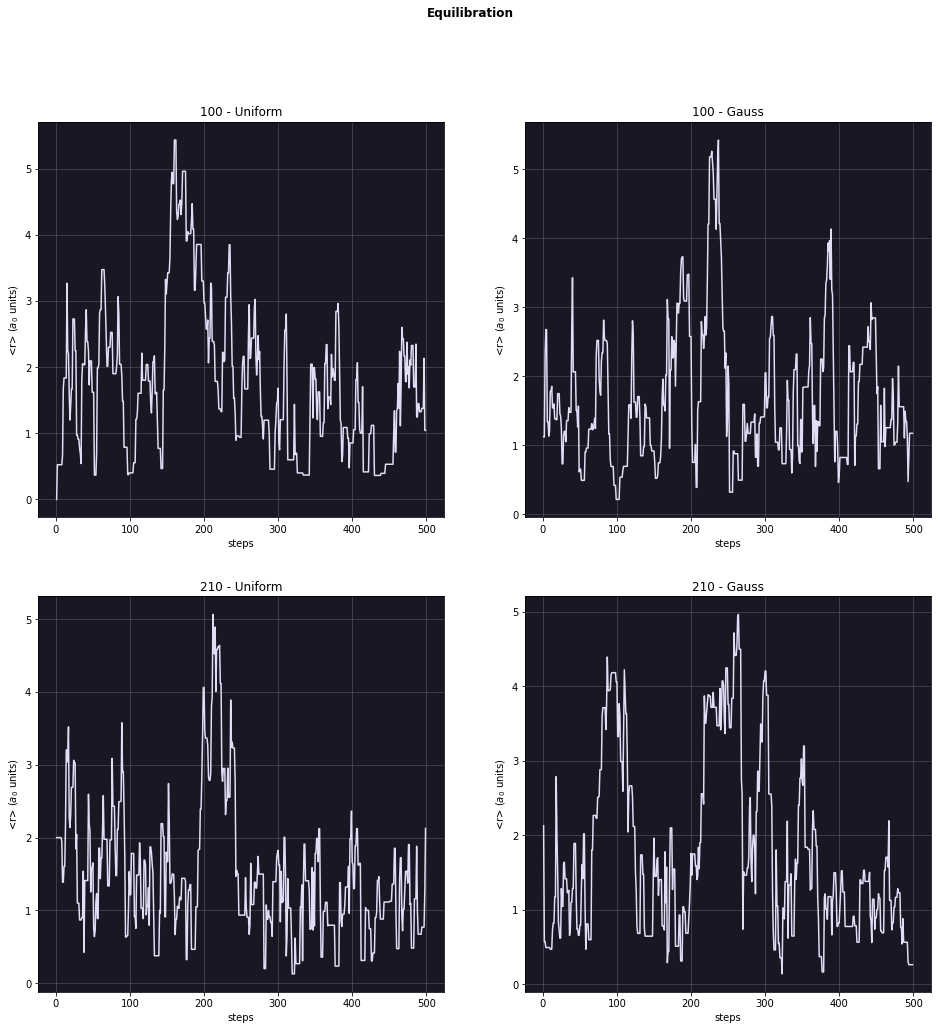

In [13]:
fig=plt.figure(figsize=(16, 16))
MultiplotSetup(fig,2,2)
plt.suptitle('Equilibration', weight='bold')

#100 - unif
plt.subplot(221)
plt.title("100 - Uniform")
plt.xlabel('steps')
plt.ylabel('<r> ($a_0$ units)')

data = np.genfromtxt("out/051-equi_100_unif.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]

plt.plot(x,y,color=el1)

#100 - gauss
plt.subplot(222)
plt.title("100 - Gauss")
plt.xlabel('steps')
plt.ylabel('<r> ($a_0$ units)')

data = np.genfromtxt("out/051-equi_100_gaus.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]

plt.plot(x,y,color=el1)

plt.subplot(223)
plt.title("210 - Uniform")
plt.xlabel('steps')
plt.ylabel('<r> ($a_0$ units)')

data = np.genfromtxt("out/051-equi_210_unif.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]

plt.plot(x,y,color=el1)

plt.subplot(224)
plt.title("210 - Gauss")
plt.xlabel('steps')
plt.ylabel('<r> ($a_0$ units)')

data = np.genfromtxt("out/051-equi_210_gaus.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]

plt.plot(x,y,color=el1)

plt.show()

For datablocking we used `N_BLOCKS` blocks with `STEPS_PER_BLOCK` steps each -where: 

In [16]:
conf_db=LoadConf("in/051-datablocking-conf.inl",int)
PrintConf(conf_db)

N_BLOCKS           100
STEPS_PER_BLOCK    10000


### 1s orbital

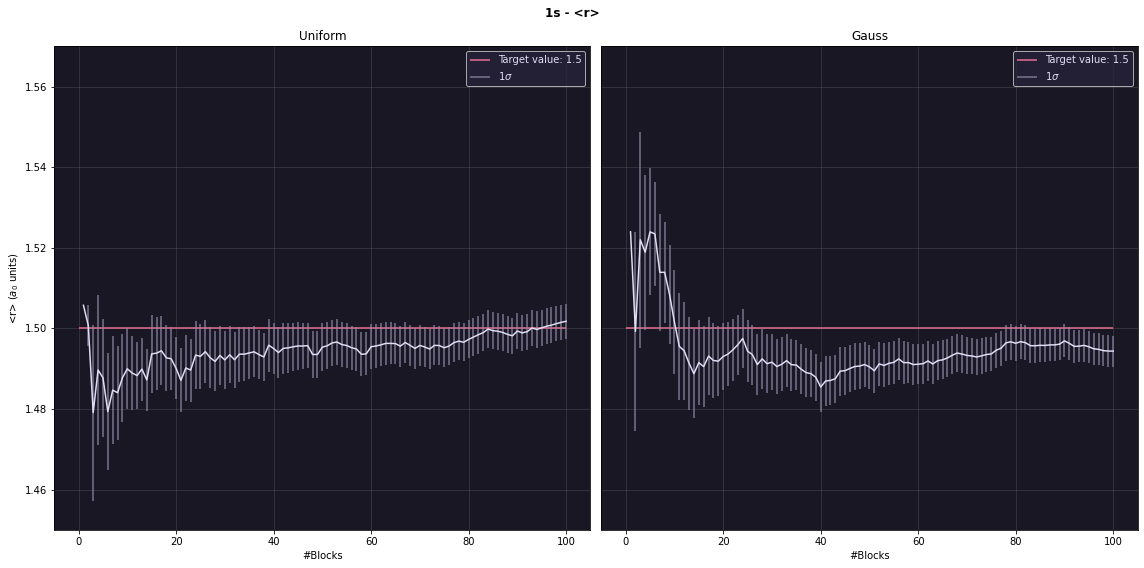

In [21]:
fig=plt.figure(figsize=(16, 8))
MultiplotSetup(fig,1,2)
plt.suptitle('1s - <r>', weight='bold')

y_inf=1.45
y_sup=1.57

#uniform 
plt.subplot(121)
plt.title("Uniform")
plt.xlabel('#Blocks')
plt.ylabel('<r> ($a_0$ units)')

data = np.genfromtxt("out/051-r_100_unif.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,2]
e=data[:,3]

plt.ylim(y_inf,y_sup)
plt.hlines(1.5,0, conf_db["N_BLOCKS"],color=el3, label="Target value: 1.5")
Errbar1Sigma(x,y,e)

Legend()

#gauss 
plt.subplot(122)
plt.title("Gauss")
plt.tick_params(left=False,labelleft=False)
plt.xlabel('#Blocks')

data = np.genfromtxt("out/051-r_100_gaus.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,2]
e=data[:,3]

plt.ylim(y_inf,y_sup)
plt.hlines(1.5,0, conf_db["N_BLOCKS"],color=el3, label="Target value: 1.5")
Errbar1Sigma(x,y,e)

Legend()


plt.tight_layout()
plt.show()

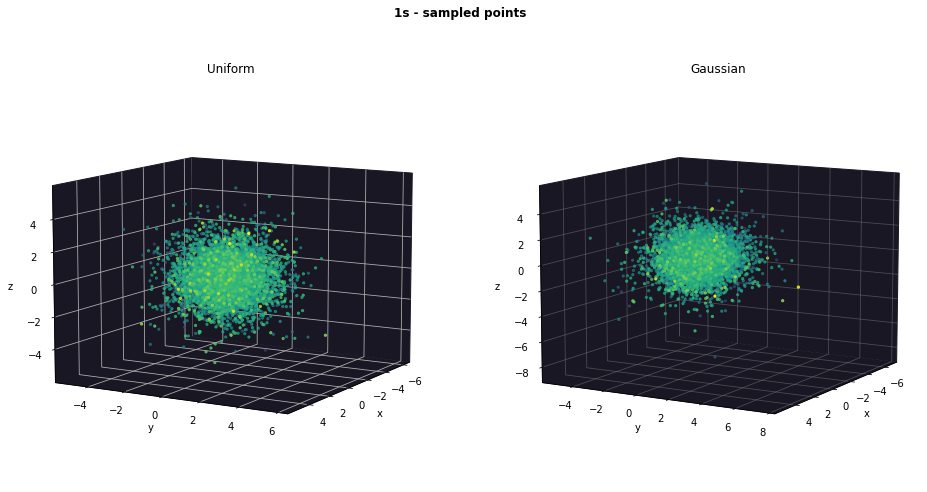

In [14]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('1s - sampled points', weight='bold')
theta_d=10
phi_d=30
theta_r=radians(theta_d)
phi_r=radians(phi_d)

# 1s uniform
ax = fig.add_subplot(1, 2, 1, projection='3d')
plt.title("Uniform")

data = np.genfromtxt("out/051-points_100_unif.csv", delimiter=",", skip_header=0)

X=data[:,0]
Y=data[:,1]
Z=data[:,2]

## Use color to mimic depth
ax.scatter(X, Y, Z, c=X*cos(theta_r)*cos(phi_r) +Y*cos(theta_r)*sin(phi_r) +Z*sin(theta_r),marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(theta_d, phi_d)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.5)
ax.w_xaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_yaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_zaxis.set_pane_color(rgb(bg1)+(1,))

# 1s gauss
ax = fig.add_subplot(1, 2, 2, projection='3d')
plt.title("Gaussian")

data = np.genfromtxt("out/051-points_100_gaus.csv", delimiter=",", skip_header=0)

X=data[:,0]
Y=data[:,1]
Z=data[:,2]

ax.scatter(X, Y, Z, c=X*cos(theta_r)*cos(phi_r) +Y*cos(theta_r)*sin(phi_r) +Z*sin(theta_r),marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(theta_d, phi_d)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.5)
ax.w_xaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_yaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_zaxis.set_pane_color(rgb(bg1)+(1,))

### 2p orbital

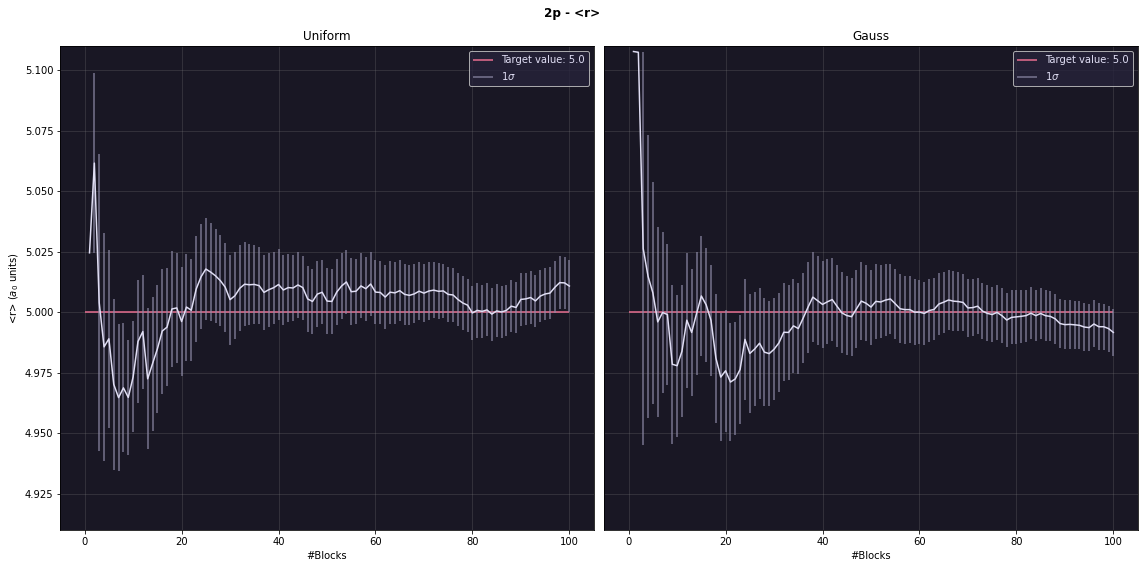

In [20]:
fig=plt.figure(figsize=(16, 8))
MultiplotSetup(fig,1,2)
plt.suptitle('2p - <r>', weight='bold')

y_inf=4.91
y_sup=5.11

#uniform 
plt.subplot(121)
plt.title("Uniform")
plt.xlabel('#Blocks')
plt.ylabel('<r> ($a_0$ units)')

data = np.genfromtxt("out/051-r_210_unif.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,2]
e=data[:,3]

plt.ylim(y_inf,y_sup)
plt.hlines(5,0, conf_db["N_BLOCKS"],color=el3, label="Target value: 5.0")
Errbar1Sigma(x,y,e)

Legend()

#gauss 
plt.subplot(122)
plt.title("Gauss")
plt.tick_params(left=False,labelleft=False)
plt.xlabel('#Blocks')

data = np.genfromtxt("out/051-r_210_gaus.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,2]
e=data[:,3]

plt.ylim(y_inf,y_sup)
plt.hlines(5,0, conf_db["N_BLOCKS"],color=el3, label="Target value: 5.0")
Errbar1Sigma(x,y,e)

Legend()

plt.tight_layout()
plt.show()


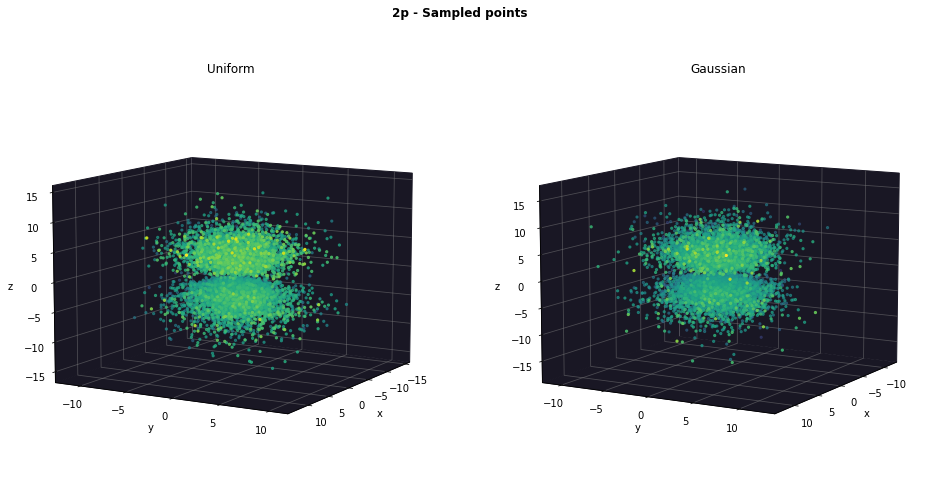

In [51]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('2p - Sampled points', weight='bold')
theta_d=10
phi_d=30
theta_r=radians(theta_d)
phi_r=radians(phi_d)

# 2p unif
ax = fig.add_subplot(1, 2, 1, projection='3d')
plt.title("Uniform")

data = np.genfromtxt("out/051-points_210_unif.csv", delimiter=",", skip_header=0)

X=data[:,0]
Y=data[:,1]
Z=data[:,2]

ax.scatter(X, Y, Z, c=X*cos(theta_r)*cos(phi_r) +Y*cos(theta_r)*sin(phi_r) +Z*sin(theta_r),marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(theta_d, phi_d)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.5)
ax.w_xaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_yaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_zaxis.set_pane_color(rgb(bg1)+(1,))

#2p gauss
ax = fig.add_subplot(1, 2, 2, projection='3d')
plt.title("Gaussian")

data = np.genfromtxt("out/051-points_210_gaus.csv", delimiter=",", skip_header=0)

X=data[:,0]
Y=data[:,1]
Z=data[:,2]

ax.scatter(X, Y, Z, c=X*cos(theta_r)*cos(phi_r) +Y*cos(theta_r)*sin(phi_r) +Z*sin(theta_r),marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(theta_d, phi_d)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.5)
ax.w_xaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_yaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_zaxis.set_pane_color(rgb(bg1)+(1,))


plt.show()

There seems to be no palpable difference from Uniform and Gauss sampling, and the results of the simulation agree well with the theoretical values.

## Appendix - equilibration
One might be wondering what happens if we choose a starting point where the pdf is low, for example a starting point far from the origin in the 1s-case. Lets pick $(0,0,50)$ and use Metropolis with uniform sampling.

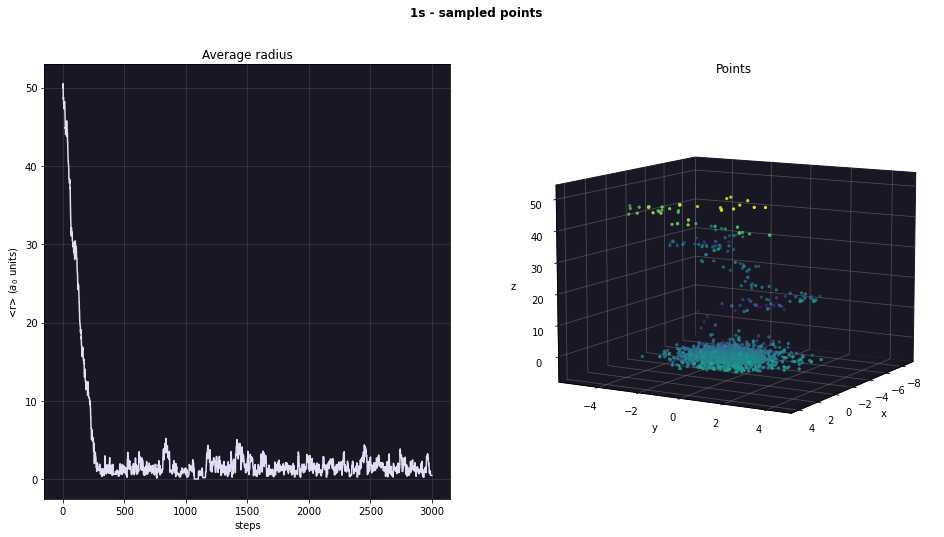

In [19]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('1s uniform - far from origin case', weight='bold')

#<r> 
data = np.genfromtxt("store/051-equir_100_unif.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,1]

plt.subplot(121)
fig.axes[0].set_facecolor(bg1)

plt.plot(x,y,color=el1)

plt.xlabel('steps')
plt.ylabel('<r> ($a_0$ units)')
plt.title("Average radius")
plt.grid(alpha=0.3)

#points
plt.suptitle('1s - sampled points', weight='bold')
theta_d=10
phi_d=30
theta_r=radians(theta_d)
phi_r=radians(phi_d)

ax = fig.add_subplot(1, 2, 2, projection='3d')
plt.title("Points")

data = np.genfromtxt("store/051-equipoints_100_unif.csv", delimiter=",", skip_header=0)

X=data[:,0]
Y=data[:,1]
Z=data[:,2]

ax.scatter(X, Y, Z, c=X*cos(theta_r)*cos(phi_r) +Y*cos(theta_r)*sin(phi_r) +Z*sin(theta_r),marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(theta_d, phi_d)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.5)
ax.w_xaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_yaxis.set_pane_color(rgb(bg1)+(1,))
ax.w_zaxis.set_pane_color(rgb(bg1)+(1,))

We clearly see the equilibration trend: $r$ takes time to stabilize around a value and the sampled point follow a clear path toward the target pdf.